<a href="https://colab.research.google.com/github/Benoit519/image-api/blob/master/COLORIZATION_with_WGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files, drive

"""
uploaded = files.upload()
"""
data = drive.mount("/content/gdrive")

import os

os.chdir("./gdrive/My Drive/colorization/")

Mounted at /content/gdrive


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import sys
from tqdm import tqdm, tqdm_notebook
import glob
import shutil
import time  # time.perf_counter()
import random

import matplotlib.pyplot as plt
import cv2

import xml.etree.ElementTree as ET

from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.preprocessing.image import image

import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Activation,
    BatchNormalization,
    UpSampling2D,
    Dropout,
    Flatten,
    Dense,
    Input,
    LeakyReLU,
    Conv2DTranspose,
    AveragePooling2D,
    Concatenate,
    Add,
    Lambda,
)


import random
import tensorflow as tf
import cv2
import datetime
import numpy as np
from keras.losses import mean_squared_error, binary_crossentropy
from keras.optimizers import Adam
import pandas as pd
import numpy as np
import os
from PIL import Image, ImageDraw
from ast import literal_eval
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Image colorization with WGAN-gp (Wasserstein GAN gradient penalty)
The purpose of this script is to train a WGAN-gp to colorize images.
WGAN-gp penalizes the critic gradient norm in order to enforce a Lipschitz constraint on the critic.

●**Reference Paper**<br>
I.Gulrajani, F.Ahmed,M.Arjovsky, V.Dumoulin and A.Courville, "***Improved Training of Wasserstein GANs***" Proc.NIPS 2017,pp.5769-5779(2017)<br>
https://arxiv.org/pdf/1704.00028.pdf<br><br>
***GAN often suffers from training instability***. The Wasserstein GAN (WGAN) makes progress toward stable training of GANs, but sometimes can still generate only poor samples or fail to converge. These problems are often due to the use of ***weight clipping in WGAN to enforce a Lipschitz constraint on the critic* ***. So, they propose an alternative to clipping weights:***penalize the norm of gradient of the critic*** with respect to its input. They say this method performs better than standard WGAN and enables stable training.<br>
*critic : WGAN calls the discriminator a critic

●**Reference scripts**<br>
The code used in the training loop and in the function that defines the WGAN-gp is taken from this notebook:
https://www.kaggle.com/amanooo/wgan-gp-keras

The generator model (used to colorize the gray images) is taken from:
https://github.com/jmt0221/ColorGan/blob/master/ColorGAN.ipynb

●**Dataset**<br>
The dataset we use can we found here : https://www.kaggle.com/shravankumar9892/colorization-dataset
It contains 30000 images (gray images and LAB images).



In [4]:
#pip install 'h5py==2.10.0' --force-reinstall

### **Parameters involved in the script**

In [5]:
# We store the parameters in the dictionnary P.
P = {}

# Images paths
P["path_gray"] = "./colorization_dataset/l/gray_scale.npy"
P["path_ab1"] = "./colorization_dataset/ab/ab/ab1.npy"
P["path_ab2"] = "./colorization_dataset/ab/ab/ab2.npy"
P["path_ab3"] = "./colorization_dataset/ab/ab/ab3.npy"

# Save dir path
P["SAVE_DIR"] = "weights_e/"

# image size and dimensions.
P["img_size"] = 224
P["channels"] = 3
P["img_shape"] = (P["img_size"], P["img_size"], P["channels"])

# gradient penalty coefficient "λ"
P["penaltyLambda"] = 10  # c_loss = f_loss - r_loss + λ･penalty

# critic iterations per generator iteration
P["trainRatio"] = 5


P["batch_size"] = 32
P["epochs"] = 100
P["ndf"] = 64

# Models

### **Generator** 

The generator ( represented as $G$ ) will take in grayscale image $x$ and produce a LAB image $G( x )$. $x$ will be a tensor of shape $( \ batch \ size \ , \ 224 \ , \ 224 \ , \ 1 \ )$ and the output $G(x)$ will have a shape $( \ batch \ size \ , \ 224 \ , \ 224 \ , \ 3 \ )$


The generator architecture is adapted from:
https://github.com/jmt0221/ColorGan/blob/master/ColorGAN.ipynb

In our case the model output a LAB image. The model learns to produce the AB channels and output a LAB images (we output the concatenation of the L input with the produced AB channels).


In [6]:
def build_generator():
        '''
        Creates the generator in Keras
        '''
        model = tf.keras.Sequential()
        
        model.add(Conv2D(64,(3,3),padding='same',strides=2, input_shape=(P["img_size"],P["img_size"],1))) #dont need pooling since stride=2 downsizes
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        #128 x 128
        
        model.add(Conv2D(128, (3,3), padding='same',strides=2))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        #64 x 64
        
        model.add(Conv2D(256, (3,3),padding='same',strides=2))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        #32 x 32 
        
        model.add(Conv2D(512,(3,3),padding='same',strides=2))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        #16 x 16
        
        
        model.add(Conv2DTranspose(256,(3,3), strides=(2,2),padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Conv2DTranspose(128,(3,3),strides=(2,2),padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Conv2DTranspose(64,(3,3),strides=(2,2),padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Conv2DTranspose(32,(3,3),strides=(2,2),padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Conv2D(2,(3,3),padding='same'))
        model.add(Activation('tanh'))
        
        l_channel = Input(shape=(P["img_size"],P["img_size"],1))
        ab_channels = model(l_channel)
        lab_channels = tf.keras.layers.Concatenate(axis=-1)([l_channel, ab_channels])
        return Model(l_channel,lab_channels)

### **Critic** 


In [7]:
def build_critic():
    input = Input(shape=P["img_shape"])
    x = Conv2D(32, kernel_size=4, strides=2, padding="same", use_bias=False)(input)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = Conv2D(128, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(128, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(1, kernel_size=1, strides=1, padding="same", use_bias=False)(x)
    x = Flatten()(x)
    x = Dense(units=1, activation=None)(x)   # activation = None
    
    model = Model(input, x)
    print("●discriminator")
    model.summary()
    return model

### **WGAN-gradient penalty Model** 

code taken from :  https://www.kaggle.com/amanooo/wgan-gp-keras

In [8]:
def build_WGANgp(generator, critic):
    #### model
    # generator image(fake image)
    z = Input(shape=(P["img_size"], P["img_size"], 1))
    f_img = generator(z)
    f_out = critic(f_img)
    # real image
    r_img = Input(shape=P["img_shape"])
    r_out = critic(r_img)
    # average image
    epsilon = K.placeholder(shape=(None, 1, 1, 1))
    a_img = Input(
        shape=(P["img_shape"]), tensor=epsilon * r_img + (1 - epsilon) * f_img
    )
    a_out = critic(a_img)

    #### loss
    # original critic(discriminator) loss
    r_loss = K.mean(r_out)
    f_loss = K.mean(f_out)
    # gradient penalty  <this is point of WGAN-gp>
    grad_mixed = K.gradients(a_out, [a_img])[0]
    norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1, 2, 3]))
    grad_penalty = K.mean(K.square(norm_grad_mixed - 1))
    penalty = P["penaltyLambda"] * grad_penalty
    # c loss
    c_loss = f_loss - r_loss + penalty

    #### discriminator update function
    c_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9).get_updates(
        critic.trainable_weights, [], c_loss
    )
    c_train = K.function(
        [r_img, z, epsilon], [r_loss, f_loss, penalty, c_loss], c_updates
    )

    #### generator update function
    g_loss = -1.0 * f_loss
    g_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9).get_updates(
        generator.trainable_weights, [], g_loss
    )
    g_train = K.function([z], [g_loss], g_updates)

    return g_train, c_train

### **Build the Model**

In [9]:
# generator Model
generator = build_generator()

# critic Model
critic = build_critic()

# WGAN-gp Training Model
G_train, C_train = build_WGANgp(generator, critic)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
●discriminator
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 32)      1536      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 64)        32768     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)       131072    
_____________________________

# Training

### **The dataset**
The dataset we use can we found here : https://www.kaggle.com/shravankumar9892/colorization-dataset

This datasets contains  4 files with the LAB representation of 30000 color images.

The file gray_scale.npy contains 30000 gray_scale images (L channel in range [0,255]).
Three other files (ab1.npy, ab2.npy, ab3.npy) contain the a and b channels associated with the gray images from gray_scale.npy.

The function written below takes as input the paths of datasets and output L, LAB in range [-1,1]), we take only 29000 images for training, the images left are kept for testing the model.

### **Prepare Training**

In [10]:
def get_gray_lab_datasets(path_gray, path_ab1, path_ab2, path_ab3):
    """
    Function to produce two datasets: gray_scale (gray images in range [-1,1]), lab_scale: (lab images in range [-1,1])
    inputs: the paths of the gray and color images
    """
    gray_scale = np.float16((np.load(path_gray)[:29000] - 127.5) / 127.5)
    ab_scale1 = np.float16((np.load(path_ab1) - 127.5) / 127.5)
    ab_scale2 = np.float16((np.load(path_ab2) - 127.5) / 127.5)
    ab_scale3 = np.float16((np.load(path_ab3) - 127.5) / 127.5)[:9000]

    ab_scale = np.concatenate([ab_scale1, ab_scale2, ab_scale3])
    del ab_scale1, ab_scale2, ab_scale3
    gray_scale = np.reshape(
        gray_scale, (len(gray_scale), P["img_size"], P["img_size"], 1)
    )
    lab_scale = np.concatenate([gray_scale, ab_scale], -1)
    del ab_scale

    return gray_scale, lab_scale


def save_g_weights(g, epoch_number):
    """
    Save the generator weights
    """
    now = datetime.datetime.now()
    save_dir = os.path.join(P["SAVE_DIR"], "{}{}".format(now.month, now.day))
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    g.save(os.path.join(save_dir, "generator_{}.h5".format(epoch_number)), True)


def save_c_weights(c, epoch_number):
    """
    Save the critic weights
    """
    now = datetime.datetime.now()
    save_dir = os.path.join(P["SAVE_DIR"], "{}{}".format(now.month, now.day))
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    c.save(os.path.join(save_dir, "critic_{}.h5".format(epoch_number)), True)

In [11]:
# Prepare the datasets x_train (gray images) and y_train (LAB images)
x_train, y_train = get_gray_lab_datasets(
    P["path_gray"], P["path_ab1"], P["path_ab2"], P["path_ab3"]
)

# list for store learning progress data
g_loss_list = []
r_loss_list = []
f_loss_list = []
f_r_loss_list = []
penalty_list = []
c_loss_list = []

In [16]:
#We keep the 1000 last gray images to test the model
x_test = np.float16((np.load(P["path_gray"])[-1000:] - 127.5) / 127.5)

array([[[ 0.961 ,  0.9688,  0.953 , ..., -0.6313, -0.6313, -0.686 ],
        [ 0.953 ,  0.961 ,  0.961 , ...,  0.5215,  0.545 , -0.5293],
        [ 0.929 ,  0.937 ,  0.937 , ...,  0.9844,  0.9766, -0.2627],
        ...,
        [ 0.2864,  0.2627,  0.1843, ..., -0.6626,  0.4275,  0.498 ],
        [-0.89  , -0.906 , -0.906 , ..., -0.655 ,  0.4038,  0.4824],
        [-0.5845, -0.569 , -0.5137, ..., -0.741 , -0.2079, -0.1451]],

       [[-0.929 , -0.937 , -0.937 , ..., -1.    , -1.    , -1.    ],
        [-0.757 , -0.851 , -0.937 , ..., -1.    , -1.    , -1.    ],
        [-0.686 , -0.8276, -0.7646, ..., -1.    , -1.    , -1.    ],
        ...,
        [-1.    , -1.    , -1.    , ..., -1.    , -1.    , -1.    ],
        [-1.    , -1.    , -1.    , ..., -1.    , -1.    , -1.    ],
        [-1.    , -1.    , -1.    , ..., -1.    , -1.    , -1.    ]],

       [[ 0.5605,  0.2393,  0.537 , ..., -0.8433, -0.9136, -0.82  ],
        [ 0.6235,  0.1294,  0.051 , ..., -0.937 , -0.9688, -0.9136],
    

In [17]:
def plot_images(imgs, rows=3, cols=3, figsize=(12,10)):
    """
    function to plot images, we use it in the training phase.
    """
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    for indx, axis in enumerate(axes.flatten()):
        img = image.array_to_img(imgs[indx])    # ndarray → PIL
        imgplot = axis.imshow(img)
        axis.set_axis_off()
    plt.tight_layout()

In [27]:
def rgb_image(lab):  
    """
    lab to rgb conversion.
    """  
    img = lab.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img

### **Perform Training** 

code adapted from :  https://www.kaggle.com/amanooo/wgan-gp-keras 

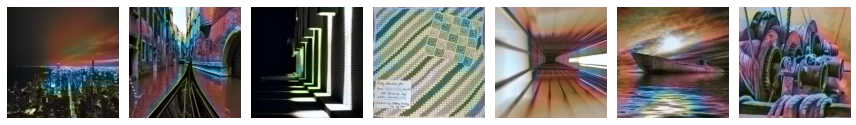

iteration:0 / c_loss:-23.052 / g_loss:-26.994


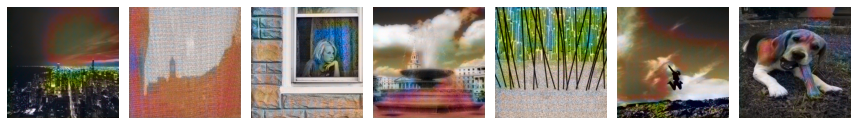

iteration:1 / c_loss:-23.283 / g_loss:15.535


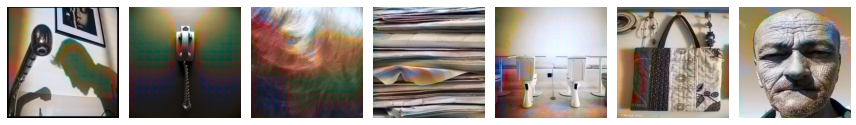

iteration:2 / c_loss:-25.847 / g_loss:38.941


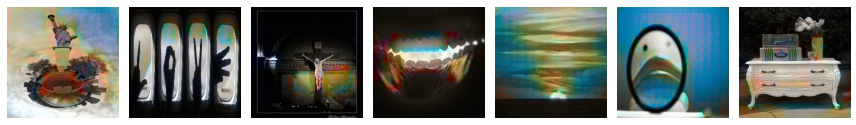

iteration:3 / c_loss:-14.768 / g_loss:11.180


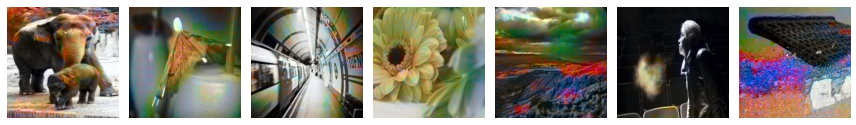

iteration:4 / c_loss:-16.891 / g_loss:2.714


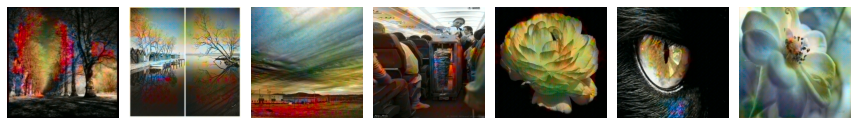

iteration:5 / c_loss:-15.890 / g_loss:2.729


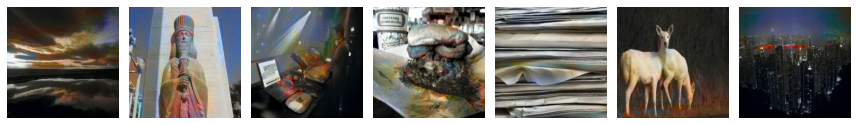

iteration:6 / c_loss:-44.187 / g_loss:-35.318


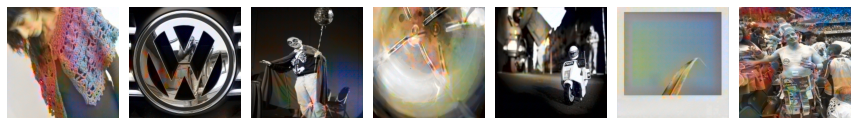

iteration:7 / c_loss:-10.986 / g_loss:11.567


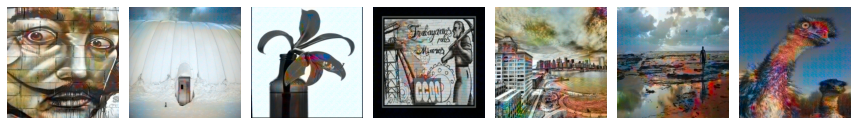

iteration:8 / c_loss:-16.484 / g_loss:-27.084


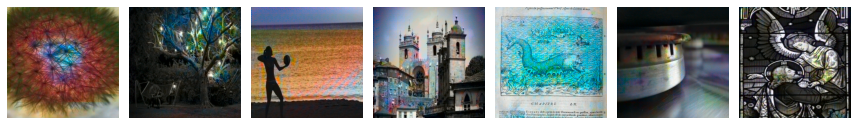

iteration:9 / c_loss:-13.048 / g_loss:-0.956


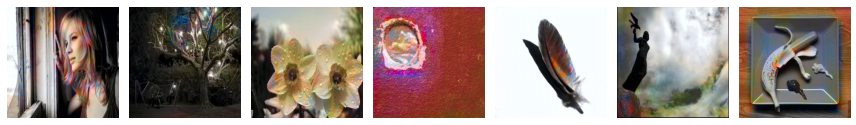

iteration:10 / c_loss:-12.154 / g_loss:0.121


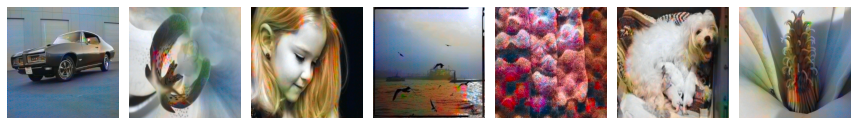

iteration:11 / c_loss:-24.535 / g_loss:-17.457


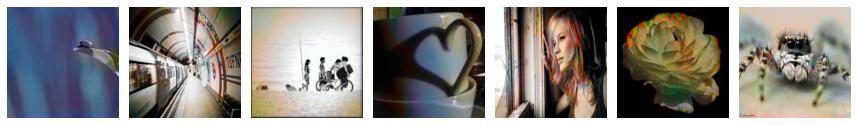

iteration:12 / c_loss:-12.221 / g_loss:11.782


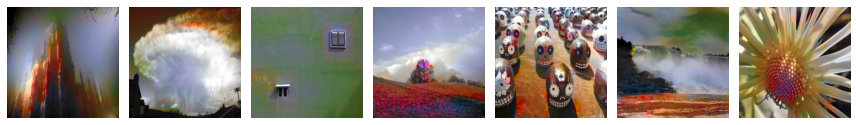

iteration:13 / c_loss:-21.718 / g_loss:-5.062


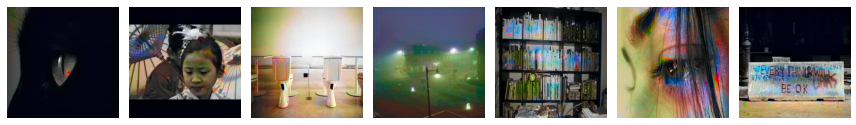

iteration:14 / c_loss:-14.062 / g_loss:7.211


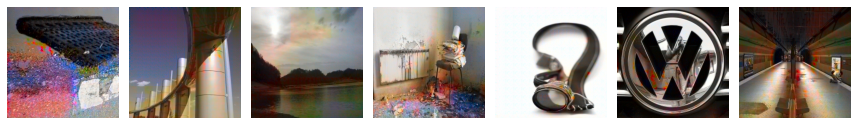

iteration:15 / c_loss:-24.134 / g_loss:6.543


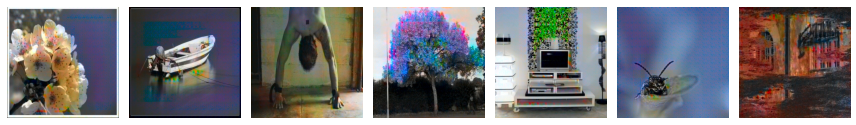

iteration:16 / c_loss:-17.016 / g_loss:-10.051


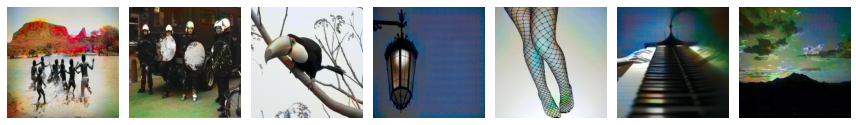

iteration:17 / c_loss:-13.481 / g_loss:7.610


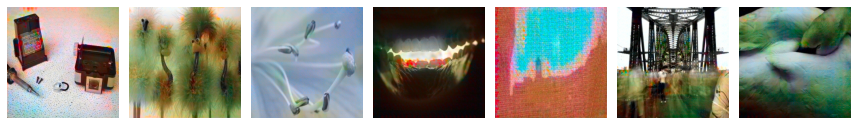

iteration:18 / c_loss:-23.079 / g_loss:-19.774


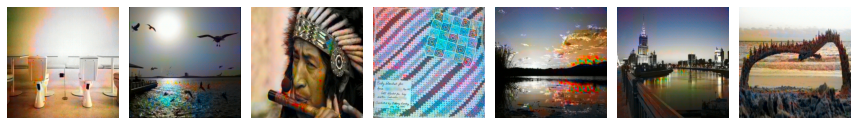

iteration:19 / c_loss:-23.971 / g_loss:-9.721


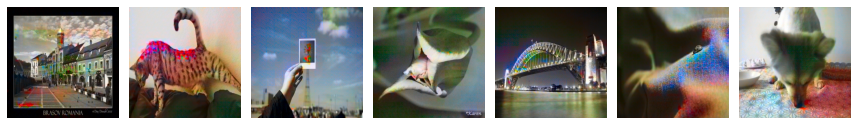

iteration:20 / c_loss:-20.716 / g_loss:37.421


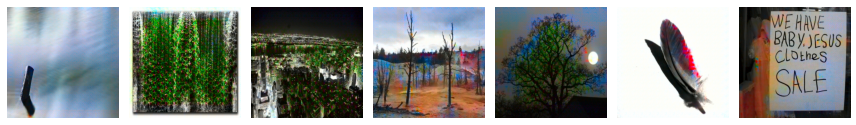

iteration:21 / c_loss:-16.868 / g_loss:-2.971


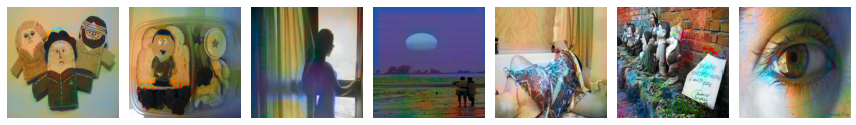

iteration:22 / c_loss:-17.639 / g_loss:3.835


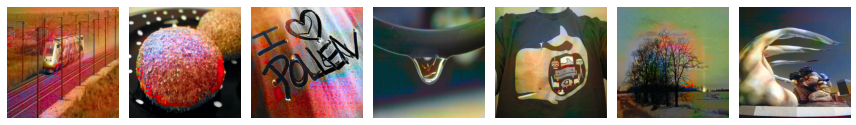

iteration:23 / c_loss:-16.748 / g_loss:27.528


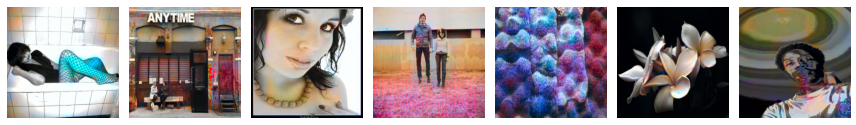

iteration:24 / c_loss:-15.156 / g_loss:18.337


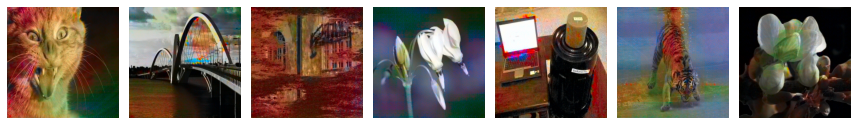

iteration:25 / c_loss:-12.004 / g_loss:6.640


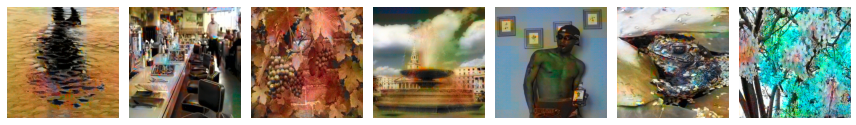

iteration:26 / c_loss:-31.448 / g_loss:-25.935


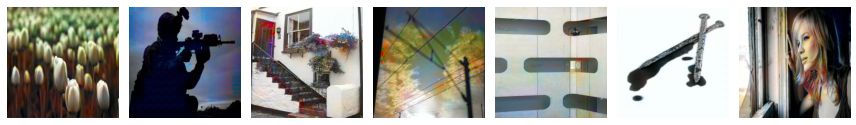

iteration:27 / c_loss:-14.477 / g_loss:-17.302


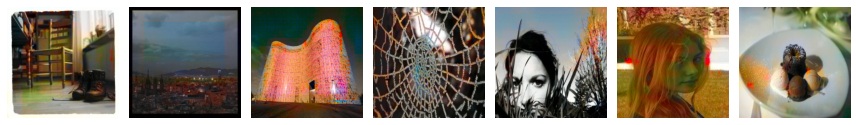

iteration:28 / c_loss:-6.315 / g_loss:-0.057


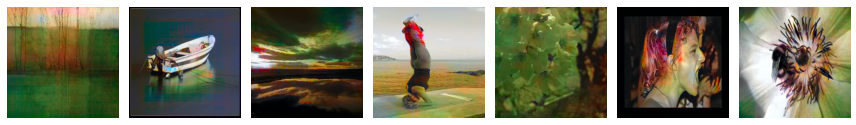

iteration:29 / c_loss:-17.867 / g_loss:6.832


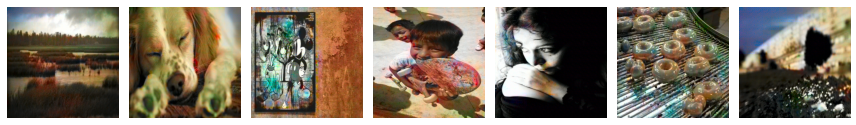

iteration:30 / c_loss:-16.674 / g_loss:27.444


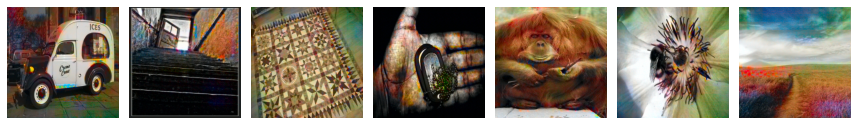

iteration:31 / c_loss:-15.940 / g_loss:-13.152


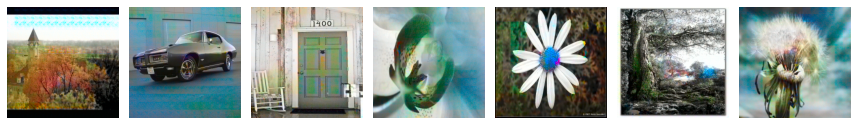

iteration:32 / c_loss:-16.797 / g_loss:14.326


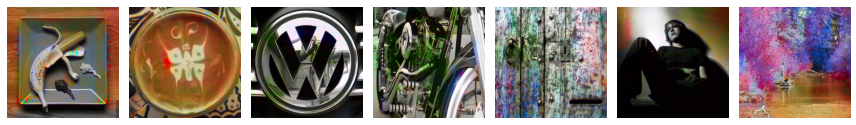

iteration:33 / c_loss:-9.789 / g_loss:8.810


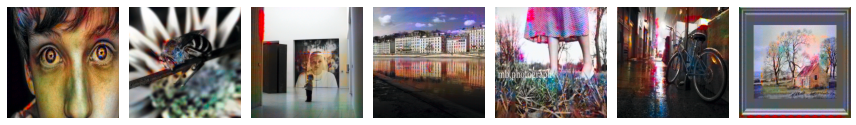

iteration:34 / c_loss:-15.931 / g_loss:-12.972


In [ ]:
iteration = 0

for epoch in range(P["epochs"]):
    permutated_indexes = np.random.permutation(x_train.shape[0])

    for index in range(int(x_train.shape[0] // P["batch_size"])):
        batch_indexes = permutated_indexes[
            index * P["batch_size"] : (index + 1) * P["batch_size"]
        ]
        image_gray_batch = x_train[batch_indexes]
        image_lab_batch = y_train[batch_indexes]

        generated_images = generator.predict(
            x=image_gray_batch, batch_size=P["batch_size"]
        )

        #### Critic
        for j in range(P["trainRatio"]):

            # Generator out Images
            f_imgs = generated_images
            # Real Images

            r_imgs = image_lab_batch
            # train the discriminator
            epsilon = np.random.uniform(size=(P["batch_size"], 1, 1, 1))
            r_loss, f_loss, penalty, c_loss = C_train(
                [r_imgs, image_gray_batch, epsilon]
            )

        #### Generator
        # Generator in
        z = image_gray_batch
        # train the generator
        g_loss = G_train([z])

        #### Record of learning progress
        # loss
        r_loss_list.append(r_loss)
        f_loss_list.append(f_loss)
        f_r_loss_list.append(f_loss - r_loss)
        penalty_list.append(penalty)
        c_loss_list.append(c_loss)
        
    # generated image sumple
    # Each epoch, we select randomly 7 gray images (from the test dataset) and colorize them
    coeffs = random.sample(range(990),7)
    gray_imgs = x_test[coeffs]
    gray_imgs = np.reshape(gray_imgs,(7,224,224,1))
    predicted_imgs = generator.predict(gray_imgs)
    predicted_imgs = 127.5*predicted_imgs + 127.5
    predicted_imgs = [rgb_image(predicted_img) for predicted_img in predicted_imgs]

    plot_images(predicted_imgs, rows=1, cols=7)
    plt.show()

    print(
            f"iteration:{iteration} / c_loss:{c_loss:.3f} / g_loss:{sum(g_loss)/len(g_loss):.3f}"
         )
    
    
    
    save_g_weights(generator, iteration)
    save_c_weights(critic, iteration)
    iteration += 1

In [ ]:
# plot loss
fig, ax = plt.subplots(5, 2, figsize=(8.27, 11.69))
for j in range(2):
    ax[0, j].plot(r_loss_list, label="r_los")
    ax[1, j].plot(f_loss_list, label="f_loss")
    ax[2, j].plot(f_r_loss_list, label="f-r_loss")
    ax[3, j].plot(penalty_list, label="penalty")
    ax[4, j].plot(c_loss_list, label="c_loss")
for i in range(5):
    ax[i, 0].set_xlim([0, 200])
    ax[i, 1].set_xlim([200, iteration])
    for j in range(2):
        ax[i, j].grid()
        ax[i, j].legend()
plt.show()